In [7]:
from DEVS import *
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statistics import mean
from math import sqrt
from scipy.stats import t

In [8]:
def DrawSampleHistogram(R,title,bins=None):
    fig = plt.figure()
    x = np.arange(len(R)) 
    plt.grid()       
    if(bins is None):    
        plt.hist(R, range=None)
    else:
        plt.hist(R, bins=bins, range=None)
    plt.title(title)
    plt.show()

In [9]:
class customerStat:
    def __init__(self):
         self.id = -1
         self.arrivalTime = -1
         self.serviceTime = -1
         self.interArrivalTime = 0
         self.serviceBegins = -1
         self.waitingTimeInQueue = 0
         self.serviceEnds = -1
         self.timeInSystem = -1
         self.idleTimeOfServer = 0
                    
# ---- Arrival Event ----
class ArrivalEvent:
    def __init__(self):
         self.eTime = 0.0
        
    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if(len(DEVS.stats)>0):
            customer.interArrivalTime = customer.arrivalTime - DEVS.stats[-1].arrivalTime

        if(DEVS.newId<maxAngents-1):       
            NextArrival = ArrivalEvent()
            NextArrival.eTime = self.eTime+random.randint(arrivalRateMin,arrivalRateMax)                
            DEVS.EQ.AddEvent(NextArrival)

        # server is Free
        if (DEVS.serverIdle == True):
            DEVS.serverIdle = False
            Service = ServiceEvent()      
            serviceTime = custm.rvs()  
            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime # current time
            Service.eTime = self.eTime+serviceTime            
            Service.id = customer.id            
            DEVS.EQ.AddEvent(Service)
        # server is Busy
        else:
            # increase waiting line
            DEVS.customerQueue.append(customer.id)

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)
        
# ---- Service (END) Event ----
class ServiceEvent:
    def __init__(self):
         self.eTime = 0.0
         self.id = 0
        
    def Execute(self):        
        ind = [i for i,val in enumerate(DEVS.stats) if val.id == self.id][0]
        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = DEVS.stats[ind].serviceEnds - DEVS.stats[ind].arrivalTime 
        DEVS.stats[ind].waitingTimeInQueue = DEVS.stats[ind].serviceBegins - DEVS.stats[ind].arrivalTime # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = DEVS.stats[ind].serviceBegins - DEVS.lastServedTime
        
        if(len(DEVS.customerQueue)>0):
            qid = DEVS.customerQueue.pop(0)
            qind = [i for i,val in enumerate(DEVS.stats) if val.id == qid][0]
            Service = ServiceEvent()
            serviceTime = custm.rvs()  
            Service.eTime = self.eTime+serviceTime
            Service.id = qid
            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime            
            DEVS.EQ.AddEvent(Service)        
        else:
            DEVS.serverIdle = True

        DEVS.lastServedTime = self.eTime

In [10]:
maxAngents = 1000
arrivalRateMin = 1
arrivalRateMax = 8
service_xk = np.arange(6)+1
service_pk = (0.1, 0.2, 0.3, 0.25, 0.1, 0.05)
custm = stats.rv_discrete(name='custm', values=(service_xk, service_pk))

### Step 1

In [11]:
serviceTime_avg=[]

desired=0.4
iters=0
max_iters=1000
alpha = 0.05


while True:
    iters+=1
    AE = ArrivalEvent()
    DEVS.EQ.AddEvent(AE)

    # simulation attributes
    DEVS.customerQueue = []
    DEVS.stats = []
    DEVS.newId = 0
    DEVS.serverIdle = True
    DEVS.lastServedTime = 0 # for Idle time

    # --- SIMULATION ---
    while DEVS.EQ.QueueSize()>0:
        DEVS.ProcessNextEvent()  
    serviceTime_avg.append(sum([x.waitingTimeInQueue for x in DEVS.stats])/len(DEVS.stats))

    serviceTime_mean=mean(serviceTime_avg)  

    s=0
    if len(serviceTime_avg) < 2:
        continue

    #значение t-критерия Стьюдента
    t_crit = t.ppf(alpha, df=iters-1)*(-1)
    for i in range(len(serviceTime_avg)):
        s+=pow(serviceTime_avg[i]-serviceTime_mean,2)
    
    s=sqrt(s/(len(serviceTime_avg)-1))
    predict=t_crit*s*sqrt(1+(1/len(serviceTime_avg)))
    trust=(t_crit*s)/sqrt(len(serviceTime_avg))
    if predict < desired:
        desired-=0.01
        iters=0
        continue
    elif iters == max_iters:
        print('Maximum iterations reached. Desired precision may not be achievable.')
        break
    

print('\nIt`s itearion', iters)
print('Desired precision:',desired)
print("Value of t-critical:", t_crit)
print('_____________________________________\n\nPrediction interval: {:.4f}'.format(serviceTime_mean),'\u00B1 {:.4f}'.format(predict))
print('Confidence interval: {:.4f}'.format(serviceTime_mean),'\u00B1 {:.4f}'.format(trust))
    


Maximum iterations reached. Desired precision may not be achievable.

It`s itearion 1000
Desired precision: 0.33999999999999997
Value of t-critical: 1.6463803454275356
_____________________________________

Prediction interval: 1.4351 ± 0.3624
Confidence interval: 1.4351 ± 0.0113


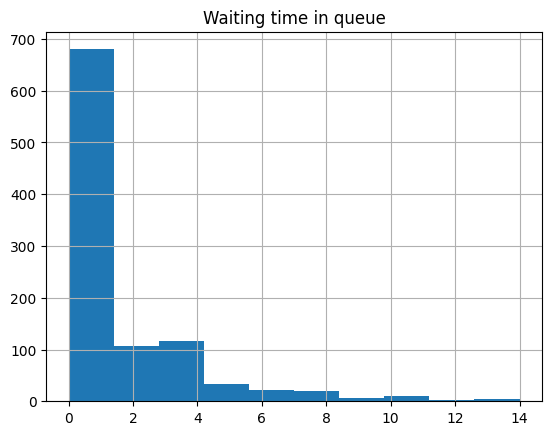

In [12]:
DrawSampleHistogram([x.waitingTimeInQueue for x in DEVS.stats],"Waiting time in queue")